I'm gonna overwrite a lot of this notebook's old content. I changed the way I'm calculating wt, and wanna test that my training worked. 

In [1]:
from pearce.emulator import OriginalRecipe, ExtraCrispy, SpicyBuffalo
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
training_file = '/scratch/users/swmclau2/xi_zheng07_cosmo_lowmsat/PearceRedMagicXiCosmoFixedNd.hdf5'
test_file = '/scratch/users/swmclau2/xi_zheng07_cosmo_test_lowmsat//PearceRedMagicXiCosmoFixedNd_Test.hdf5'
em_method = 'gp'
split_method = 'random'

In [4]:
a = 1.0
z = 1.0/a - 1.0

In [5]:
fixed_params = {'z':z}#, 'cosmo': 0}#, 'r':24.06822623}

In [6]:
v = np.array([  2.68607108,  -4.29605403, -12. ,         12.,         -11.18424935,
  -8.39772494 , -8.88556884,   9.00797499 , 12.    ,      10.56121261,  12.,
   5.50280428,   0.59482347 , -6.24363245 , -8.26644505,   0.25342135,
   0.96977814 , 12.,           3.37450278,  12. ,          7.15832218,
   0.79122102,  11.9455156 ,   1.64464882,   4.03020203])


In [7]:
param_names = ['ombh2', 'omch2', 'w0', 'ns', 'ln10As', 'H0', 'Neff', 'logM0', 'sigma_logM', 'logM1', 'alpha']

In [8]:
kernel_param_names = ['bias', 'amp']
kernel_param_names.extend(param_names)
kernel_param_names.append('amp')
kernel_param_names.extend(param_names)

In [9]:
from collections import defaultdict
metric = defaultdict(list)
for pname, _v in zip(kernel_param_names, v):
    metric[pname].append(_v)

In [10]:
np.random.seed(0)
emu = SpicyBuffalo(training_file, method = em_method, hyperparams={'metric':metric}, fixed_params=fixed_params,
                 custom_mean_function = 'linear', downsample_factor = 0.1)

/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:287: UserWarning: WARNING: NaN detected. Skipped 21 points in training data.
  warnings.warn('WARNING: NaN detected. Skipped %d points in training data.' % (num_skipped))


40000 18


In [11]:
print emu.get_param_names()

['ombh2', 'omch2', 'w0', 'ns', 'ln10As', 'H0', 'Neff', 'logM0', 'sigma_logM', 'logM1', 'alpha']


In [12]:
emu.scale_bin_centers

array([  0.09581734,   0.13534558,   0.19118072,   0.27004994,
         0.38145568,   0.53882047,   0.76110414,   1.07508818,
         1.51860241,   2.14508292,   3.03001016,   4.28000311,
         6.04566509,   8.53972892,  12.06268772,  17.0389993 ,
        24.06822623,  33.99727318])

In [13]:
rbins = np.logspace(-1.1, 1.6, 19)
print (rbins[1:]+rbins[:-1])/2

[  0.09581733   0.13534558   0.19118072   0.27004994   0.38145568
   0.53882047   0.76110414   1.07508817   1.51860241   2.14508292
   3.03001016   4.28000311   6.04566509   8.53972892  12.06268772
  17.0389993   24.06822623  33.99727318]


In [14]:
#v = [  5.30324096,  -2.92565173,  -4.42429766,  -2.48246708,  10.0699553,                                                           
#  -8.69248089,   0.15083459,  -4.72773171,   1.49655743,   1.17087069,                                                                 
#   0.97997249,  -1.91976981,   7.17709699, -10.26944746,  10.37865121,                                                                 
#   0.50210416,  12.01525603,   5.89975769,   4.78413158,  -1.33582408,                                                                 
#  -9.94571436,   6.50103759,   9.70125021, -11.7173251,   -0.10738552] 

#v = [-12.,          -5.56039378,   5.01999226,   9.63986449, -12.,
# -12.,          -2.13397232,   7.90203306, -12.,           0.51574787,
#   7.25074046,  -1.28201782,   2.84486642, -12.,         -12.,
#  12.,          -7.75414731,  12.,          12.,         -12.,
#   5.15929851, -12.,           0.53369134,  -3.81346879,  -6.9684267, ]

#v = [ -1.14028239, -12.,          -8.08712614 , -1.51590059 ,  2.66822232,
# -12.,         -10.17631757,   6.17448276,   6.2380102,  -12.,
#  -3.63076923,  -1.3260091,    1.84463374,  -2.57120539,   0.42652469,
#   0.94596673,   2.04145112,  -5.13442469,  12.,           8.86492205,
# -12.,           2.44659378,  12.,           2.10889078,   9.36958256]

v = [ 12. ,         12. ,         12.  ,        12.   ,       12.     ,     12.,
  11.67920429 ,  6.81656135 , 12.   ,        1.92715272 , 12.    ,       7.72884642,
  12.,        -12.     ,      2.57697301,  12. ,          8.85016763,
   9.96558899 ,  6.24704116 , 12.      ,    12.   ,      -12.    ,     -12. ,        -12.,
  12.,       ]

v = np.ones_like(v)*12.0

#[ -8.16992654,   8.67223223,  -2.21244202,  -8.9034059,    2.12923655,
#  -9.85755136,   8.6699058,    1.24032812,  -0.41040494 ,  1.93942663,
#   3.70688402,   5.53623883,  10.27060377,  -8.96397854,  -1.54633767,
#   6.72846738,  -9.38415988,  -9.68900453,  -3.5219898,   -9.2396184,
#  10.60952486,  -2.12807193,  -9.92944798,  -2.87456867,  -8.28144359]

#[-2.30321746, -6.,          2.74986581, -0.59132415,  0.74564814, -1.47243557,
#5.38958859,  2.36982126,  5.35110678,  1.6798139,   6.,          2.82272942,
#6.        ]

#[ 6.         -6.         -2.95890662 -6.         -3.63039154  6.
# -0.93930637 -6.         -6.          2.2162459   6.          2.75175138
#  5.09211467]

In [15]:
if hasattr(emu, "_emulator"):
    emu._emulator.set_parameter_vector(v) 
    emu._emulator.recompute()
else:
    for _emulator in emu._emulators:
        _emulator.set_parameter_vector(v)
        _emulator.recompute()

In [16]:
params = {}
for pname in emu.get_param_names():
    if pname == 'r':
        continue
    low, high = emu.get_param_bounds(pname)
    params[pname] = np.random.uniform(low, high)
    
print params

{'logM1': 14.267701848157271, 'Neff': 3.6095427706197905, 'logM0': 13.578807613765713, 'sigma_logM': 0.2502193887675708, 'H0': 73.31620420249872, 'w0': -0.5886073500474833, 'omch2': 0.10271736946651576, 'ln10As': 3.0459840518637358, 'alpha': 1.031390598923265, 'ns': 0.9832511796584299, 'ombh2': 0.021913242278466367}


In [17]:
pred_y = emu.emulate_wrt_r(params)[0]
print pred_y

[ 2.78432305  2.66540613  2.53332999  2.26570146  2.09139426  1.98099381
  1.84430818  1.85192735  1.77500799  1.43224549  1.08347859  0.92592548
  0.6738203   0.34153705  0.13289383 -0.135843   -0.34813545 -0.59491316]


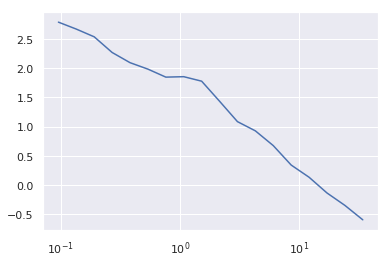

In [18]:
plt.plot(emu.scale_bin_centers, pred_y)
plt.xscale('log')

In [19]:
gof = emu.goodness_of_fit(test_file, statistic = 'log_frac')
#print gof.mean(), np.median(gof)
for g in gof:
    print g.mean(), np.median(g)

0.0166637564266 0.0153943204176
0.0159135775874 0.0143586504424
0.0150881172738 0.0136572802046
0.0156568550658 0.014578439827
0.0137700129004 0.012948652029
0.0119548836086 0.0107203434047
0.0105614808591 0.00903365744858
0.00997102096228 0.00837985671523
0.0116328008408 0.0100816669693
0.0152521001372 0.0137610926042
0.0213306791916 0.0202543833186
0.0221083636758 0.0187472061078
0.0253729778295 0.0230421535435
0.0347401011195 0.0311599943042
0.0826807374455 0.0656086601807
0.269473594369 0.0824457394676
0.552182681116 0.0299442841845
0.0723637117784 0.0217388539732


In [20]:
%%bash
cp 

cp: missing file operand
Try 'cp --help' for more information.


In [21]:
#print g.mean(), np.median(g)

In [22]:
pred_y, y = emu.goodness_of_fit(test_file, statistic = None)
#print gof.mean(), np.median(gof)

([array([    0.,     0.,     0.,     0.,    13.,   212.,   776.,  1590.,
          2249.,  2160.]),
  array([    0.,     0.,     0.,     0.,    42.,   370.,  1046.,  1933.,
          2465.,  1144.]),
  array([    0.,     0.,     0.,     3.,   115.,   582.,  1377.,  2116.,
          2498.,   309.]),
  array([    0.,     0.,     0.,    17.,   253.,   877.,  1810.,  2039.,
          1911.,    93.]),
  array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
           7.40000000e+01,   4.62000000e+02,   1.28100000e+03,
           2.02200000e+03,   2.03900000e+03,   1.10100000e+03,
           2.00000000e+01]),
  array([    0.,     0.,    12.,   199.,   778.,  1763.,  1902.,  1977.,
           369.,     0.]),
  array([    0.,     0.,    67.,   424.,  1248.,  1922.,  1719.,  1488.,
           132.,     0.]),
  array([    0.,     0.,     0.,   791.,  1909.,  1782.,  1792.,   700.,
            26.,     0.]),
  array([    0.,     0.,     0.,  1273.,  2373.,  1671.,  1484.,   199.,
         

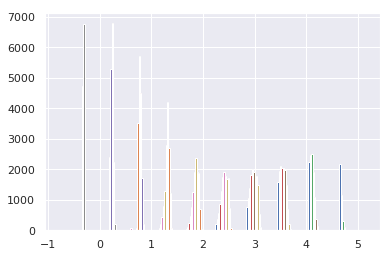

In [23]:
plt.hist(y)

([array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   2.00000000e+00,   2.51000000e+02,
           1.06300000e+03,   1.85300000e+03,   2.77100000e+03,
           1.06000000e+03]),
  array([    0.,     0.,     0.,     0.,    26.,   500.,  1307.,  2065.,
          2810.,   292.]),
  array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.00000000e+00,   1.38000000e+02,   7.35000000e+02,
           1.69400000e+03,   2.19300000e+03,   2.17000000e+03,
           6.90000000e+01]),
  array([    0.,     0.,     0.,     8.,   302.,  1117.,  2011.,  2290.,
          1264.,     8.]),
  array([    0.,     0.,     0.,    76.,   564.,  1577.,  2000.,  2362.,
           421.,     0.]),
  array([    0.,     0.,     5.,   253.,   932.,  1922.,  1875.,  1863.,
           150.,     0.]),
  array([    0.,     0.,    64.,   470.,  1478.,  1890.,  1893.,  1164.,
            41.,     0.]),
  array([    0.,     0.,    10.,   942.,  1995.,  1772.,  1937.,

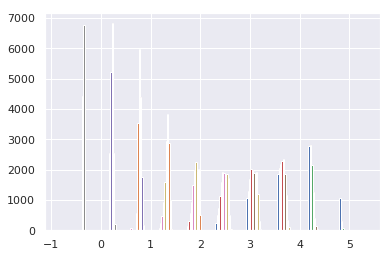

In [24]:
plt.hist(pred_y)

([array([    54.,    244.,    669.,   1732.,   4294.,  13807.,  17063.,
           1914.,    181.,     23.]),
  array([    44.,    202.,    604.,   1678.,   4281.,  14441.,  16732.,
           1790.,    208.,     20.]),
  array([    39.,    167.,    521.,   1636.,   4256.,  15161.,  16247.,
           1714.,    240.,     19.]),
  array([    34.,    153.,    481.,   1525.,   4258.,  15969.,  15494.,
           1804.,    265.,     17.]),
  array([  2.40000000e+01,   1.46000000e+02,   4.41000000e+02,
           1.47500000e+03,   4.20600000e+03,   1.67230000e+04,
           1.48070000e+04,   1.89300000e+03,   2.72000000e+02,
           1.30000000e+01]),
  array([  2.20000000e+01,   1.34000000e+02,   4.11000000e+02,
           1.43300000e+03,   4.14500000e+03,   1.72970000e+04,
           1.42720000e+04,   2.00300000e+03,   2.77000000e+02,
           6.00000000e+00]),
  array([    21.,    132.,    404.,   1392.,   4105.,  17726.,  13868.,
           2083.,    267.,      0.]),
  array([     

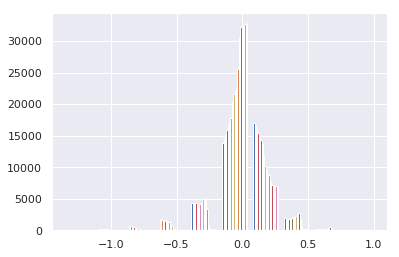

In [ ]:
plt.hist(emu.y)

In [ ]:
plt.hist(np.log10(gof));

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6087: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 18 x 7000)
  '(shape is %d x %d)' % inp.shape[::-1])


KeyboardInterrupt: 

In [ ]:
plt.hist(emu.y)

In [ ]:
for i in xrange(50):    
    params = {}

    for pname in emu.get_param_names():
        if pname == 'r':
            continue
        low, high = emu.get_param_bounds(pname)
        params[pname] = np.random.uniform(low, high)
    pred_y = emu.emulate(params)[0]
    print pred_y
    #print params

In [ ]:
for i, (g, r) in enumerate(zip(gof, emu.scale_bin_centers)):
    print r, g.mean(), np.median(g)
    #plt.hist(np.log10(g))
    #plt.show()

In [ ]:
n_cosmo_params = 7
loo_cosmo = emu.x[0, 0,  :n_cosmo_params]

loo_cosmo_idxs = np.all(emu.x[:, :,:n_cosmo_params] == loo_cosmo, axis =2)
train_x, train_y, train_yerr = emu.x[~loo_cosmo_idxs, :], emu.y[ ~loo_cosmo_idxs], emu.yerr[ ~loo_cosmo_idxs]
test_x, test_y, test_yerr = emu.x[loo_cosmo_idxs, :], emu.y[loo_cosmo_idxs], emu.yerr[loo_cosmo_idxs]

In [ ]:
model = emu._emulator
model.compute(train_x, train_yerr)

In [ ]:
pred_y = model.predict(train_y, test_x, False, False, False)*emu._y_std + emu._y_mean


In [ ]:
np.mean(np.abs((pred_y-test_y)/test_y))
#np.mean(np.abs((pred_y-train_y)/train_y))

In [ ]:
        queue_skipper: True
        system: sherlock
        n_jobs: 400
        max_time: 6
resids = np.abs(emu.y*emu._y_std+emu._y_mean - ypred)

In [ ]:
np.mean(resids/(emu.y*emu._y_std+emu._y_mean))

In [ ]:
ypred.mean(), emu._y_mean

In [ ]:
test_gof = emu.goodness_of_fit(test_file, statistic = 'log_frac')
print test_gof.mean()

In [ ]:
test_gof = emu.goodness_of_fit(test_file, statistic = 'frac')
print test_gof.mean()

In [ ]:
plt.hist(np.log10(test_gof));

In [ ]:
test_x

In [ ]:
(emu.x*emu._x_std) + emu._x_mean

In [ ]:
emu.get_param_names()

In [ ]:
test_x_white, test_y_white = (test_x - emu._x_mean)/(emu._x_std + 1e-5), (test_y - emu._y_mean)/(emu._y_std + 1e-5)

In [ ]:
model = emu._emulator

In [ ]:
pred_y_white = model.predict(emu.y, test_x_white, False, False, False)

In [ ]:
pred_y = pred_y_white*emu._y_std + emu._y_mean

In [ ]:
plt.plot(pred_y[:100], label = 'pred')
plt.plot(test_y[:100], label = 'truth')

plt.legend(loc = 'best')

In [ ]:
test_y.mean(), emu._y_mean, pred_y.mean()

In [ ]:
test_y.std(), emu._y_std, pred_y.std()

In [ ]:
plt.hist(pred_y_white, bins = np.linspace(-3, 3, 100), label = 'Pred')
plt.hist(test_y_white, bins = np.linspace(-3, 3, 100), label = 'Test', alpha = 0.4);
plt.legend(loc = 'best')